## IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## IGNORING POSSIBLE WARNINGS THAT APPEARS IN THE NOTEBOOK

In [2]:
from warnings import simplefilter

simplefilter(action = 'ignore', category = Warning)

## IMPORTING THE DATA

In [3]:
customer_churn = pd.read_csv('files_for_lab/customer_churn.csv')

## CONVERTING THE TOTAL CHARGES COLUMN TO NUMERIC

In [4]:
customer_churn['TotalCharges'] = pd.to_numeric(customer_churn['TotalCharges'], errors = 'coerce')

## ENCODING THE TARGET VARIABLE INTO 0 AND 1 VALUES

In [5]:
customer_churn['Churn'] = customer_churn['Churn'].replace({'No': 0, 'Yes': 1})

## CHECKING THE NULL VALUES IN THE DATAFRAME

In [6]:
print('\nCOLUMNS WITH NAN VALUES')
print('-----------------------\n')

for column in customer_churn.columns:
    if customer_churn[column].isna().sum() > 0:
        print(f'- {column} -> {customer_churn[column].isna().sum()}')


COLUMNS WITH NAN VALUES
-----------------------

- TotalCharges -> 11


## PERFORMING THE DATA TRAIN TEST SPLIT STEP

In [7]:
X = customer_churn.drop('Churn', axis = 1)
y = customer_churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## THERE IS ONLY ONE COLUMN WITH NAN VALUES: TOTAL CHARGES. REPLACING THEM WITH THE MEAN

In [8]:
total_charges_avg = X_train['TotalCharges'].mean()
X_train['TotalCharges'] = X_train['TotalCharges'].fillna(total_charges_avg)
X_test['TotalCharges'] = X_test['TotalCharges'].fillna(total_charges_avg)

## SELECTING THE INPUT VARIABLES THAT WE ARE GOING TO USE IN THE MODEL

In [9]:
X_train = X_train[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
X_test = X_test[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]

## SCALING ONLY THE CONTINUOUS DATA USING STANDARD SCALER

In [10]:
X_train_numeric = X_train[['tenure', 'MonthlyCharges', 'TotalCharges']]
X_test_numeric = X_test[['tenure', 'MonthlyCharges', 'TotalCharges']]

scaler = StandardScaler().fit(X_train_numeric)

X_train_numeric_scaled = pd.DataFrame(data = scaler.transform(X_train_numeric), 
                                      columns = X_train_numeric.columns, 
                                      index = X_train.index)

X_test_numeric_scaled = pd.DataFrame(data = scaler.transform(X_test_numeric), 
                                     columns = X_test_numeric.columns, 
                                     index = X_test.index)

X_train_scaled = pd.concat([X_train_numeric_scaled, X_train['SeniorCitizen']], axis = 1)
X_test_scaled = pd.concat([X_test_numeric_scaled, X_test['SeniorCitizen']], axis = 1)

## TRAINING A LOGISTIC REGRESSION MODEL

In [11]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

LogisticRegression()

## GENERATING THE METRICS AND THE RESULTS OF THE MODEL

In [12]:
def model_metrics(model, testing_x, testing_y):

    predictions = model.predict(testing_x)

    accuracy = accuracy_score(testing_y, predictions)
    precision = precision_score(testing_y, predictions)
    recall = recall_score(testing_y, predictions)
    f1 = f1_score(testing_y, predictions)

    return accuracy, precision, recall, f1

model_accuracy, model_precision, model_recall, model_f1 = model_metrics(lr, X_test_scaled, y_test)

## EVALUATING THE PERFORMANCE OF THE MODEL

In [13]:
print('\nLOGISTIC REGRESSION METRICS')
print('---------------------------\n')

print(f'- Accuracy: {round(model_accuracy, 2)}')
print(f'- Precision: {round(model_precision, 2)}')
print(f'- Recall: {round(model_recall, 2)}')
print(f'- F1: {round(model_f1, 2)}')


LOGISTIC REGRESSION METRICS
---------------------------

- Accuracy: 0.81
- Precision: 0.7
- Recall: 0.48
- F1: 0.57


## CHECKING THE IMBALANCE OF THE TARGET VARIABLE

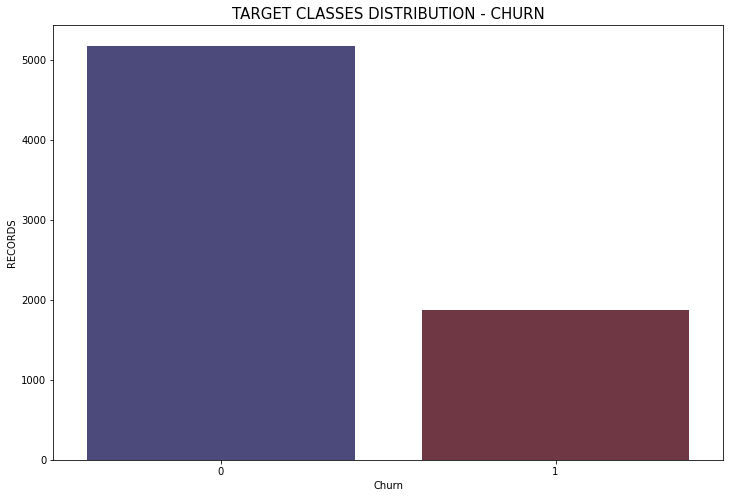

In [14]:
fig = plt.figure(figsize = (12, 8))
sns.countplot(x = 'Churn', data = customer_churn, palette = 'icefire')
plt.title('TARGET CLASSES DISTRIBUTION - CHURN', fontsize = 15)
plt.ylabel('RECORDS')
plt.show()

## UPSAMPLING THE DATA TO SEE IF WE CAN INCREASE THE BALANCE OF OUR MODEL

In [15]:
def over_sampling(training_x, training_y):

    smote = SMOTE(random_state = 100, k_neighbors = 3)
    X_train_scaled_SMOTE, y_train_SMOTE = smote.fit_resample(training_x, training_y)

    return X_train_scaled_SMOTE, y_train_SMOTE    

X_train_scaled_SMOTE, y_train_SMOTE = over_sampling(X_train_scaled, y_train)

## CHECKING THE RESULTS USING THE OVERSAMPLING TECHNIQUE

In [16]:
lr_over = LogisticRegression()
lr_over.fit(X_train_scaled_SMOTE, y_train_SMOTE)
model_accuracy_ov, model_precision_ov, model_recall_ov, model_f1_ov = model_metrics(lr_over, X_test_scaled, y_test)

print('\nLOGISTIC REGRESSION METRICS - OVERSAMPLING')
print('------------------------------------------\n')

print(f'- Accuracy: {round(model_accuracy_ov, 2)}')
print(f'- Precision: {round(model_precision_ov, 2)}')
print(f'- Recall: {round(model_recall_ov, 2)}')
print(f'- F1: {round(model_f1_ov, 2)}')


LOGISTIC REGRESSION METRICS - OVERSAMPLING
------------------------------------------

- Accuracy: 0.75
- Precision: 0.51
- Recall: 0.77
- F1: 0.62


## UNDERSAMPLING THE DATA TO SEE IF WE CAN INCREASE THE BALANCE OF OUR MODEL

In [17]:
def under_sampling(training_x, training_y):

    under_sampler = RandomUnderSampler(sampling_strategy = 0.5)
    X_train_scaled_under, y_train_under = under_sampler.fit_resample(training_x, training_y)

    return X_train_scaled_under, y_train_under  

X_train_scaled_under, y_train_under = under_sampling(X_train_scaled, y_train)

## CHECKING THE RESULTS USING THE UNDERSAMPLING TECHNIQUE

In [18]:
lr_under = LogisticRegression()
lr_under.fit(X_train_scaled_under, y_train_under)
model_accuracy_un, model_precision_un, model_recall_un, model_f1_un = model_metrics(lr_under, X_test_scaled, y_test)

print('\nLOGISTIC REGRESSION METRICS - OVERSAMPLING')
print('------------------------------------------\n')

print(f'- Accuracy: {round(model_accuracy_un, 2)}')
print(f'- Precision: {round(model_precision_un, 2)}')
print(f'- Recall: {round(model_recall_un, 2)}')
print(f'- F1: {round(model_f1_un, 2)}')


LOGISTIC REGRESSION METRICS - OVERSAMPLING
------------------------------------------

- Accuracy: 0.79
- Precision: 0.61
- Recall: 0.59
- F1: 0.6
